# Volatility Analysis
This notebook adresses Chapter 3 of our research project, namely analyzing the stability of stock beta (exposure to the market) over time.

In [1]:
import pandas as pd
import numpy as np
# import scipy.stats as stats
# import wrds
# import pandas_market_calendars as mcal
from datetime import date, timedelta, datetime
# import matplotlib.pyplot as plt
# import seaborn as sns
from IPython.display import clear_output
# conn = wrds.Connection(wrds_username='kaihvc')

## Data Collection
The goal of this section is to generate a dataset of weekly returns (Fri-Fri) for each stock in our universe.

### Querying WRDS for Daily Returns
We query the WRDS CRSP stock database for daily returns for any stock with a 2020 $10mil market cap (adjusted for inflation using the GDP deflator)

In [2]:
# WRDS database request & processing
# build SQL query using inflation-adjusted mcaps

# load inflation-adjusted market caps from file (equivalents of 2020 $10mil)
def get_cutoffs(filename):
    cutoffs = pd.read_csv(filename)[['observation_date', 'Cutoff Value']]
    cutoffs['year'] = pd.to_datetime(cutoffs['observation_date']).apply(lambda x: x.year)
    cutoffs = cutoffs.set_index('year').drop(columns='observation_date')
    return cutoffs

# build query, filtering using inflation-adjusted mcap values
def build_query(start_dt, end_dt, adjusted_mcaps):
    query = f"SELECT cusip, date, ret FROM crsp.dsf WHERE date>='{str(start_dt)}' AND date<='{str(end_dt)}' AND ("
    for i, year in enumerate(adjusted_mcaps.loc[start_dt.year:].index):
        query += f"(EXTRACT(YEAR FROM date)={year} AND prc*shrout>={int(adjusted_mcaps.loc[year][0] / 1000)})"
        query += " OR " if i < len(adjusted_mcaps.loc[start_dt.year:].index) - 1 else ")"
    return query
        
# get daily returns
def get_returns(start_dt, end_dt, adjusted_mcaps, username='kaihvc'):
    conn = wrds.Connection(wrds_username=username)
    query = build_query(start_dt, end_dt, adjusted_mcaps)
    df = conn.raw_sql(query)
    return df

In [2]:
# parameters
# we'll use the 1950 inflation-adjusted equivalent of a 2020 $10mil mcap minimum, and do more fine-grained filtering later
start_dt = date(1950, 1, 1)
end_dt = date(2021, 1, 1)

In [4]:
# query returns
requery = False
if requery:
    exec_start = datetime.now()
    print("Querying WRDS for daily returns...")
    daily_rets = get_returns(start_dt, end_dt, get_cutoffs('inflation_adjustments.csv'))
    print(f"Query complete in {str(datetime.now() - exec_start)}, writing to disk...")
    stage_start = datetime.now()
    daily_rets.to_csv('wrds_results/daily_rets_adjusted.csv')
    print(f"Disk write complete in {str(datetime.now() - stage_start)}")
    print(f"Download complete in {str(datetime.now() - exec_start)}")

### Converting Daily Data to Weekly Data
To convert our daily data into weekly data, we'll neeed to delineate the weeks (excluding market holidays, defining minimum days, etc.). We'll then geometrically expand each week's daily returns ($r_d$ for each day $d$) to get the weekly return $r_w$ as:  
$r_w = ((1 + r_1) \cdot (1 + r_2) \cdot (1 + r_3) \cdot (1 + r_4) \cdot (1 + r_5)) - 1$ 

In [5]:
def pd_process_weekly(df, start_dt, end_dt):
    
    # takes ~25-30 min on my machine (16G, 2.8GHz) all told; most spent on the aggregation
    # group by cusip & weeks, then geometrically expand week groups to get weekly returns
    df['date'] = pd.to_datetime(df['date'])
    grouper = pd.Grouper(key='date', freq='W-MON')
    grouped = df.groupby(by=['cusip', grouper], observed=True)
    weekly_rets = grouped.agg({'ret': lambda x: (x + 1).product() - 1})
    
    return weekly_rets

In [6]:
# calculate returns
load = True
if load:
    recalc = False
    if recalc:
        if 'daily_rets' not in globals():
            print("Loading daily returns from file...")
            daily_rets = pd.read_csv('wrds_results/daily_rets_adjusted.csv', index_col=0)
        exec_start = datetime.now()
        weekly_rets = pd_process_weekly(daily_rets, start_dt, end_dt)
        print(f"Processing complete in {str(datetime.now() - exec_start)}, writing to disk...")
        weekly_rets.to_csv('wrds_results/weekly_rets_adjusted.csv')
        print(f'Weekly returns downloaded in {str(datetime.now() - exec_start)}')
    else:
        weekly_rets = pd.read_csv('wrds_results/weekly_rets_adjusted.csv', index_col=[0, 1])
        weekly_rets.index = weekly_rets.index.set_levels([weekly_rets.index.levels[0], pd.to_datetime(weekly_rets.index.levels[1])])
        print('Weekly returns loaded')

Weekly returns loaded


## Data Processing
Once we have weekly returns, we want to calculate their standard deviations over a ~6-month period for each stock, which will be our primary source of data on the stocks' volatility.

### Generating 6mo. Standard Deviations
Calculating standard deviations is relatively straightforward; the main caveat is generating the periods. We'll be using periods of _approximately_ 26 weeks, with occasional corrections to avoid drift (we want to start as close to the first trading week of the year, or the 26th week of the year, as we can).

In [3]:
def get_days(start_dt, end_dt):
    nyse = mcal.get_calendar('NYSE')
    return [day.date() for day in nyse.valid_days(start_date=str(start_dt), 
                                                end_date=str(end_dt))]

def get_weeks(start_dt, end_dt):
    weeks = []

    # get trading days and divide into weeks, rolling over on the given rollover day
    current_week = []
    days = get_days(start_dt, end_dt)
    for i, day in enumerate(days):
        # append to current week
        current_week.append(day)

        #end of the week check
        if i+1<len(days):
            next_day = days[i+1]
            if next_day.weekday() < day.weekday(): #if the next day's weekday comes before the current, then the next_day is in a new week
                weeks.append(current_week)
                current_week = []
            elif (next_day-day).days > 4: #if the condition above didnt pass, check that >4 days didnt pass as well
                weeks.append(current_week)
                current_week = []

    # append final week, even if it wasn't a full week period
    if current_week: weeks.append(current_week)

    return weeks

def get_periods(weeks):
    periods = []
    start_date = weeks[0][0]
    end_date = None
    for i in range(len(weeks)-1):
        start = weeks[i][0] #this monday
        end = weeks[i][-1]  #this friday

        next_start = weeks[i+1][0] #next monday
        next_end = weeks[i+1][-1]  #next friday

        #if the current friday is in december, and the next weeks friday is in january, this is the end of one period
        #the very next week will be the very start of the period\
        if end.month == 12 and next_end.month == 1:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
        #if the last day is in june, and the next weeks last day is in july, this is the end of one period
        #the very next week will be the very start of the period
        if end.month == 6 and next_end.month == 7:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
    periods.append([start_date, weeks[i+1][-1]])
    for i in periods:
        i[1] += timedelta(days=3)
    return periods

In [8]:
# calculate standard deviations of ~26 week periods; 
# must have min_valid_weeks (default 20) out of 26 to be valid
def get_6mo_stds(weekly_rets, periods, min_valid_weeks=20):
    
    num_pers = len(periods)
    devs_df_list = []
    devs = pd.DataFrame(index=weekly_rets.index.levels[0], columns=['P' + str(i) for i in range(len(periods))])

    for i, per in enumerate(periods):
        
        clear_output(wait=True)
        iter_start = datetime.now()

        filter_counts = weekly_rets.loc[(slice(None), 
                                    slice(per[0], 
                                          per[1] - timedelta(days=1))), 
                                   :].groupby('cusip').count().rename(columns={'ret': 'count'})
        agg_devs = weekly_rets.loc[(slice(None), 
                                    slice(per[0], 
                                          per[1] - timedelta(days=1))), 
                                   :].groupby('cusip').agg(np.std).loc[filter_counts['count'] >= min_valid_weeks]
        devs.loc[agg_devs.index, 'P' + str(i)] = agg_devs.values.flatten()
        devs_df_list.append(devs)
                
        iter_time = datetime.now() - iter_start
        print(f'Cusip {i + 1}/{num_pers} complete in {str(iter_time)}')
        print(f'Est. completion in {str(iter_time * (num_pers - (i + 1)))}')
        
    try:
        devs = pd.concat(devs_df_list).astype(float)
        return devs
    except MemoryError:
        print('Memory error encountered - attempting to remedy by dropping weekly_rets')
        del weekly_rets
        try:
            devs = pd.concat(devs_df_list)
            return devs
        except MemoryError:
            print('Remedy failed - reload weekly_rets and buy more memory!')
            return -1
    
    return -1

In [2]:
recalc = False
stacked = True
if recalc:
    exec_start = datetime.now()
    periods = get_periods(get_weeks(start_dt, end_dt))
    df_devs = get_6mo_stds(weekly_rets, periods)
    print('Writing to file...')
    df_devs.to_csv('wrds_results/deviations.csv')
    print(f'Done in {str(datetime.now() - exec_start)}')
else:
    if stacked:
        df_devs = pd.read_csv('wrds_results/deviations.csv',index_col=0).iloc[:, :-2].stack().astype(float)
        df_devs.to_csv('wrds_results/devs_stacked.csv')
    else:
        df_devs = pd.read_csv('wrds_results/deviations.csv',index_col=0).iloc[:, :-2]
    print('Standard deviations loaded')

Standard deviations loaded


# Gathering Market Data
We need to do the same for the market index overall, so we'll re-query data for value-weighted market indices and group it into weekly segments.

In [9]:
def beta_process_weekly(df, start_dt, end_dt):
    
    # takes ~25-30 min on my machine (16G, 2.8GHz) all told; most spent on the aggregation
    # group by weeks, then geometrically expand week groups to get weekly market index returns
    grouper = pd.Grouper(key='date', freq='W-MON')
    grouped = df.groupby(by=grouper, observed=True)
    weekly_rets = grouped.agg({'vwretd': lambda x: (x + 1).product() - 1})
    
    return weekly_rets

In [7]:
recalc = False
if recalc:
    exec_start = datetime.now()
    df_market_index = conn.get_table(library='crsp', table='dsi')
    df_market_index['date'] = pd.to_datetime(df_market_index['date'])
    df_market_index['comp_date'] = [elt.date() for elt in df_market_index['date']]
    df_market_index = pd.DataFrame(df_market_index.loc[df_market_index['comp_date'] >= start_dt - timedelta(days=7)][['date', 'vwretd']])

    weekly_market = beta_process_weekly(df_market_index, start_dt, end_dt)
    weekly_market.to_csv('wrds_results/weekly_market_index_returns.csv')
    print(f'Complete in {str(datetime.now() - exec_start)}')
else:
    weekly_market = pd.read_csv('wrds_results/weekly_market_index_returns.csv', index_col=0)
    weekly_market.index = pd.to_datetime(weekly_market.index)
    print('Loaded weekly market index returns')

Loaded weekly market index returns


# Calculating Market Correlations
We'll also need to calculate correlations of each stock's weekly returns with the market index's weekly returns for each 6mo period.

In [5]:
def get_period_corrs(stock_weekly, market_weekly, periods):
    
    num_cusips = len(stock_weekly.index.levels[0])
    per_starts = pd.to_datetime([per[0] for per in periods] + [periods[-1][1] + timedelta(days=1)])
    
    cusips = stock_weekly.index.get_level_values(0)
    dates = stock_weekly.index.get_level_values(1)
    final_df = stock_weekly.groupby([cusips, pd.cut(dates, per_starts, include_lowest=True)])
    final_df = final_df.agg({'ret': lambda x: np.corrcoef(x.values, market_weekly.loc[x.index.get_level_values(1)].values.flatten())[0][1]})
    
    return final_df.rename(columns={'ret': 'corr'})

def get_period_stds(market_weekly, periods):
    per_starts = pd.to_datetime([per[0] for per in periods] + [periods[-1][1] + timedelta(days=1)])
    
    dates = market_weekly.index
    final_df = market_weekly.groupby(pd.cut(dates, per_starts, include_lowest=True)).std()
    
    return final_df

In [10]:
recalc_corrs = False
recalc_stds = False
if recalc_corrs:
    exec_start = datetime.now()
    periods = get_periods(get_weeks(start_dt, end_dt))[:-2]
    corr_df = get_period_corrs(weekly_rets, weekly_market, periods)
    corr_df.to_csv('wrds_results/stock_market_correlations.csv')
    print(f'Done in {str(datetime.now() - exec_start)}')
else:
    corr_df = pd.read_csv('wrds_results/stock_market_correlations.csv', index_col=[0, 1]).rename(columns={'ret': 'corr'})
    print('Correlations loaded')
    
if recalc_stds:
    exec_start = datetime.now()
    periods = get_periods(get_weeks(start_dt, end_dt))[:-2]
    market_stds = get_period_stds(weekly_market, periods)
    market_stds.to_csv('wrds_results/market_stds.csv')
    print(f'Done in {str(datetime.now() - exec_start)}')
else:
    market_stds = pd.read_csv('wrds_results/market_stds.csv', index_col=0)
    print('Market standard deviations loaded')

Correlations loaded
Market standard deviations loaded


# Calculating Market Beta
Now that we have data for stock-to-market correlations, as well as stock & market standard deviations for each 26-week period, we can calculate the stock's market beta over that period.

In [17]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4049920 entries, ('00002130', '(1950-01-02 23:59:59.999999999, 1950-07-03]') to ('Y9530810', '(2019-07-01, 2019-12-31]')
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   corr    float64
dtypes: float64(1)
memory usage: 176.6+ MB


In [18]:
df_devs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4107776 entries, 00002130 to Y9530810
Columns: 140 entries, (1950-01-02 23:59:59.999999999, 1950-07-03] to (2019-07-01, 2019-12-31]
dtypes: float64(140)
memory usage: 4.3+ GB


In [19]:
market_stds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, (1950-01-02 23:59:59.999999999, 1950-07-03] to (2019-07-01, 2019-12-31]
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vwretd  140 non-null    float64
dtypes: float64(1)
memory usage: 2.2+ KB


In [12]:
# match indices
df_devs.columns = corr_df.index.levels[1]

In [4]:
def calculate_beta(stock_to_market_corrs, stock_stds, market_stds, copy_safe=True):
    if copy_safe:

        beta = (stock_to_market_corrs['corr'] * stock_stds.stack(dropna=False))
        beta = beta / np.array([market_stds[idx] for idx in beta.index.get_level_values(1)])
        
        # corr * stockstd / marketstd
        
    return beta

def calculate_beta_piecewise(stock_to_market_corrs, stock_stds, market_stds):
    
    full_size = len(stock_to_market_corrs)
    splits = [0, int(full_size / 4), int(full_size / 2), int(3 * full_size / 4), full_size]
    print(f'Calculating beta in {full_size} chunks...')
    
    for i in range(len(splits) - 1):
        beta_chunk = (stock_to_market_corrs['corr'].iloc[splits[i]:splits[i + 1]] * stock_stds[splits[i]:splits[i + 1]])
        beta_chunk = beta_chunk / np.array([market_stds[idx] for idx in beta_chunk.index.get_level_values(1)])
        beta_chunk.to_csv(f'wrds_results/ch3/chunk{i}.csv')
        
    print(f'Beta saved to disk in {full_size} chunks')
        
    # beta = corr * stockstd / marketstd
    
def concatenate_beta(num_splits):
    beta = []
    for i in num_splits:
        chunk = pd.read_csv(f'wrds_results/ch3/chunk{i}.csv', index_col=[0, 1])
        beta.append(chunk)
        
    beta = pd.concat(beta)

In [16]:
recalc = True
if recalc:
#     beta = calculate_beta(corr_df, df_devs, market_stds)
    calculate_beta_piecewise(corr_df, df_devs, market_stds)
#     beta.to_csv('wrds_results/beta.csv')
#     df_beta = combined_df['corr']

MemoryError: Unable to allocate 4.28 GiB for an array with shape (575088640,) and data type object

In [ ]:
print(f'Done at {str(datetime.now())}')

In [ ]:
beta

# Ranking Stocks by Volatility
Now that we have data for volatility, we want to rank it in order to perform some stability analysis on it. We'll do this using both straight deciles, as well as which portion of the distribution the standard error of each value falls in.

#### Deciles
These are straight decile rankings - each ranking bin (1-10) contains 10% of the data.

In [7]:
# discretize into 10 bins
def discretize(df_devs, stderr=False, waiting_period=0):
    
    print('Beginning discretization...')
    
    if waiting_period > 0:
        for i, row in df_devs.iterrows():
            idxs = row.dropna().index[:waiting_period]
            row[idxs] = np.nan
            
    # BUGFIX 3/24: we shouldn't be dropping columns, because that'll mess up our transitions later on
#     df_devs = df_devs.dropna(axis='columns', how='all')
    
    df_disc = pd.DataFrame(columns=df_devs.columns)
    num_cols = len(df_devs.columns)
    
    if stderr:
        intervals = [pd.Interval(elt, elt + 0.5) for elt in np.arange(-2, 2, 0.5)]
        intervals = [pd.Interval(-np.inf, -2)] + intervals + [pd.Interval(2, np.inf)]    
        intervals = pd.IntervalIndex(intervals)
    
    for i, col in enumerate(df_devs.columns):
        iter_start = datetime.now()
        clear_output(wait=True)
        
        if stderr:
            
            stderr_col = (df_devs[col] - np.nanmean(df_devs[col])) / np.nanstd(df_devs[col])

            ''' 
                note: it's possible that not every period will include 10 categories, since this
                bins by set intervals rather than quantiles of the data itself.
            ''' 
            # all inline cause memory issues - save as much as we can, right?
            discretized = pd.cut(stderr_col, intervals, include_lowest=True)
            
            # BUGFIX 3/24: confirmed that labels are always the same
            labels = range(1, 11)
            vals = np.array(discretized.cat.rename_categories(labels))
        else:
            # however, this method *should* always include 10 categories for each period
            vals = pd.qcut(df_devs[col], 10, labels=range(1, 11))
        
        df_disc[col] = vals
        
        iter_time = datetime.now() - iter_start
        print(f'Column {i + 1}/{num_cols} complete in {str(iter_time)}')
        print(f'Est. completion in {str(iter_time * (num_cols - (i + 1)))}')
        
    return df_disc

In [29]:
load = False
recalc = False
if load:
    if recalc:
        exec_start = datetime.now()
        df_deciles = discretize(df_devs)
        print('Writing to file...')
        df_deciles.to_csv('wrds_results/ch1/deciles.csv')
        print(f'Done in {str(datetime.now() - exec_start)}')
    else:
        df_deciles = pd.read_csv('wrds_results/ch1/deciles.csv', index_col=0)
        print('Deciles loaded')

Deciles loaded


#### Standard Errors
These are rankings depending on which portion of the normal distribution the data fall into, defined by standard deviation. For given data point $d$, the bins are:   $ d < -2 \sigma, -2 \sigma < d < -1.5 \sigma, \cdots, 1.5 \sigma < d < 2 \sigma, 2 \sigma < d $

In [2]:
load = True
recalc = False
if load:
    if recalc:
        exec_start = datetime.now()
        df_stderrs = discretize(df_devs, stderr=True)
        print('Writing to file...')
        df_stderrs.to_csv('wrds_results/ch1/stderr.csv')
        print(f'Done in {str(datetime.now() - exec_start)}')
    else:
        df_stderrs = pd.read_csv('wrds_results/ch1/stderr.csv', index_col=0)
        print('Stderrs loaded')

Stderrs loaded


### Markov Modeling
Finally, for our stability analysis, we'll use the discretizations of our data (both deciles/standard errors) as "states" and build a Markov model to analyze how stocks transition between bins. We do this for each transition matrix, as well as one final

In [3]:
def get_transition_matrix(df, n_quantiles, stderr=False):
    transition_matrices = []
    periods = [elt[:10] for elt in df.columns]
    if not len(periods) % 20 == 0:
        periods = periods[:-(len(periods) % 20)]
    n_decades = len(periods) // 20
    for i in range(n_decades):
        transition_matrices.append(np.zeros((n_quantiles + 1, n_quantiles + 1)))
                    
    # do it again, but column-major cause Pandas
    for c_idx in range(len(periods) - 1):
        # start iteration
        print(f'Adding period {periods[c_idx]}...')
        clear_output(wait=True)
        iter_start = datetime.now()
        
        col = df[df.columns[c_idx]]
        next_col = df[df.columns[c_idx + 1]]
        for r_idx in range(len(df)):
            elt = col[r_idx]
            next_elt = next_col[r_idx]
            if (not np.isnan(elt)) and (not np.isnan(next_elt)):
                transition_matrices[c_idx // 20][int(elt)][int(next_elt)] += 1
            

        print(f'Period {periods[c_idx]} complete in {str(datetime.now() - iter_start)}')
        
    # row-major cause Dr. Ikenberry doubts my results
#     num_rows = len(df)
#     for i, row in df.iterrows():
#         # start iteration
#         print(f'Adding row {i}...')
#         clear_output(wait=True)
#         iter_start = datetime.now()
        
#         for c_idx in range(len(row) - 1):
#             elt = row[c_idx]
#             next_elt = row[c_idx + 1]
#             if (not np.isnan(elt)) and (not np.isnan(next_elt)):
#                 transition_matrices[c_idx // 20][int(elt)][int(next_elt)] += 1
            
#         iter_time = datetime.now() - iter_start
#         print(f'Row {i + 1}/{num_rows} complete in {str(iter_time)}; est {str(iter_time * (num_rows - i - 1))} remaining')
            
    # normalize transition matrix (decades & overall)
    overall_matrix = np.zeros((n_quantiles + 1, n_quantiles + 1))
    for decade in range(n_decades):
        overall_matrix += transition_matrices[decade]
        for i in range(n_quantiles + 1):
            mat_sum = np.sum(transition_matrices[decade][i])
            if mat_sum > 0:
                transition_matrices[decade][i] /= mat_sum
                
    for i in range(n_quantiles + 1):
        mat_sum = np.sum(overall_matrix[i])
        if mat_sum > 0:
            overall_matrix[i] /= mat_sum
            
    return transition_matrices + [overall_matrix]

In [4]:
dec = False
stderr = True
if dec:
    transition_mats_dec = get_transition_matrix(df_deciles, 10)
    for i in range(len(transition_mats_dec) - 1):
        np.save(f'wrds_results/ch1/transition_mat_deciles_{str(1950 + i * 10)}', transition_mats_dec[i])
    np.save('wrds_results/ch1/transition_mat_deciles_overall', transition_mats_dec[-1])
if stderr:
    transition_mats_stderr = get_transition_matrix(df_stderrs, 10, stderr=True)
    for i in range(len(transition_mats_stderr) - 1):
        np.save(f'wrds_results/ch1/transition_mat_stderr_{str(1950 + i * 10)}', transition_mats_stderr[i])
    np.save('wrds_results/ch1/transition_mat_stderr_overall', transition_mats_stderr[-1])

Period P138 complete in 0:00:43.842051



## Results
Here we display heatmaps of each decade's transition matrix, as well as one final one.

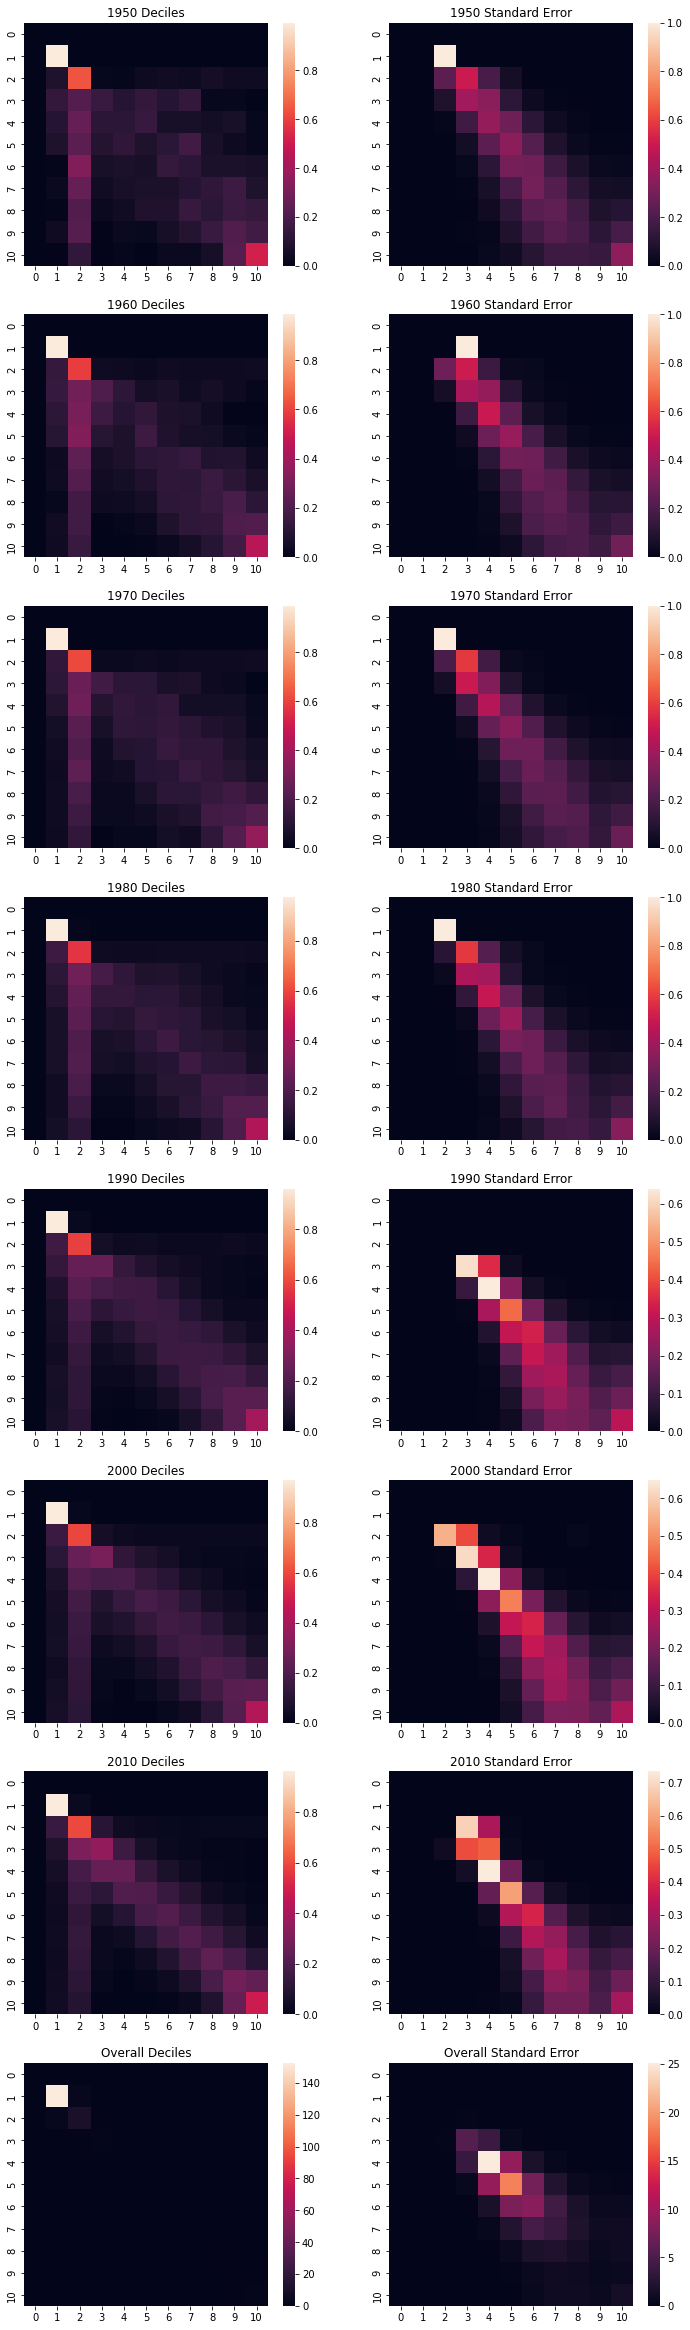

In [9]:
n_decades = 7
fig, axes = plt.subplots(nrows=n_decades + 1, ncols=2, figsize=(12, 42))
for i in range(n_decades):
    mat = np.load(f'wrds_results/ch1/transition_mat_deciles_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][0])
    mat = np.load(f'wrds_results/ch1/transition_mat_stderr_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][1])
    
    axes[i][0].set_title(f'{str(1950 + i * 10)} Deciles')
    axes[i][1].set_title(f'{str(1950 + i * 10)} Standard Error')
    
mat = np.load(f'wrds_results/ch1/transition_mat_deciles_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][0])
mat = np.load(f'wrds_results/ch1/transition_mat_stderr_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][1])

axes[n_decades][0].set_title(f'Overall Deciles')
axes[n_decades][1].set_title(f'Overall Standard Error')
plt.show()